## RoBERTa Fine-Tuned (RQ3)

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, average_precision_score,  precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [3]:
# Load the training data 
X_train = pd.read_csv("data/X_train.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_train = pd.read_csv("data/y_train.csv", index_col=0).reset_index(drop=True)['Sentiment']

# Load the validation data 
X_val = pd.read_csv("data/X_val.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_val = pd.read_csv("data/y_val.csv", index_col=0).reset_index(drop=True)['Sentiment']

# Load the test data 
X_test = pd.read_csv("data/X_test.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_test = pd.read_csv("data/y_test.csv", index_col=0).reset_index(drop=True)['Sentiment']

One-hot encoding transforms the categorical target variable (sentiment labels) into a binary format that can be easily processed by the model.

In [4]:
# Convert the labels to one-hot encoding
y_train_onehot = tf.one_hot(y_train, depth=3)
y_val_onehot = tf.one_hot(y_val, depth=3)
y_test_onehot = tf.one_hot(y_test, depth=3)

The RoBERTa tokenizer is used to convert the raw text data into tokenized input sequences that can be processed by the RoBERTa model.

In [5]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

Now I will perform tokenization on the training, validation, and test data, using a tokenizer to convert the text data into a sequence of tokens. The following steps are taken: <br>

-  training data is tokenized using the `tokenizer.batch_encode_plus()` method, where `X_train` is converted to a list and passed as input 
-  `max_length` parameter is set to 64, which limits the maximum length of the tokenized sequences 
-  `padding` parameter is set to 'max_length', which pads the sequences to the maximum length specified 
-  `truncation` parameter is set to True, to truncate any sequences longer than the maximum length 
-  `return_token_type_ids` parameter is set to False, so that token type ids are not returned.

In [6]:
# Tokenize the training data
X_train_tokens = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = 64, # set the max length of the tokenized sequences
    padding = 'max_length',  # pad sequence to max length 
    truncation=True, # truncate sequences longer than the max length
    return_token_type_ids=False  # type IDs not returned
)

# Tokenize the validation data
X_val_tokens = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = 64,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

# Tokenize the test data
X_test_tokens = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = 64,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

After tokenizing the data, the tokenized input sequences and associated attention masks are converted to TensorFlow tensors using the `tf.constant` method, and stored in variables with names such as `X_train_pad` and `X_train_mask`. These tensors will be used as input to the RoBERTa model during training and inference.

In [7]:
# Convert the tokenized inputs to tensors
X_train_pad = tf.constant(X_train_tokens['input_ids'])
X_train_mask = tf.constant(X_train_tokens['attention_mask'])

X_val_pad = tf.constant(X_val_tokens['input_ids'])
X_val_mask = tf.constant(X_val_tokens['attention_mask'])

X_test_pad = tf.constant(X_test_tokens['input_ids'])
X_test_mask = tf.constant(X_test_tokens['attention_mask'])

In [8]:
# Define the RoBERTa model
roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=3)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Calculate class weights
le = LabelEncoder() # LabelEncoder is used to encode the target variable y_train into numerical labels 
y_train_encoded = le.fit_transform(y_train)
sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_encoded) # sample_weights are then calculated 
# sample_weights use the balanced class weighting method
# this method assigns higher weights to minority classes to address class imbalance

# Set up the optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) # define optimizer
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) # define loss function
metrics = tf.metrics.CategoricalAccuracy() # categorical accuracy is used to evaluate model performance

# Compile the model (with the specified optimizer, loss function, and metrics)
roberta_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# this will monitor the validation loss and restore the best weights when the loss does not improve for 3 epochs

# Define learning rate scheduler
def lr_scheduler(epoch, lr): # this will adjust the learning rate based on the epoch number
    if epoch > 0:
        return lr * 0.9 # learning rate is reduced by 10% after the first epoch
    return lr

scheduler_callback = LearningRateScheduler(lr_scheduler)

# Fit the model
history = roberta_model.fit(
    x=[X_train_pad, X_train_mask],
    y=y_train_onehot,
    batch_size=32,
    epochs=5,
    validation_data=([X_val_pad, X_val_mask], y_val_onehot), # monitor model's performance on the val set
    callbacks=[early_stopping, scheduler_callback],
    sample_weight=sample_weights # give higher importance to the minority classes
) 

Epoch 1/5
1167/1167 [==============================] - 314s 186ms/step - loss: 0.5930 - categorical_accuracy: 0.7783 - val_loss: 0.4368 - val_categorical_accuracy: 0.8543 - lr: 2.0000e-05
Epoch 2/5
1167/1167 [==============================] - 187s 161ms/step - loss: 0.3963 - categorical_accuracy: 0.8723 - val_loss: 0.4026 - val_categorical_accuracy: 0.8635 - lr: 1.8000e-05
Epoch 3/5
1167/1167 [==============================] - 186s 159ms/step - loss: 0.3223 - categorical_accuracy: 0.8993 - val_loss: 0.3776 - val_categorical_accuracy: 0.8767 - lr: 1.6200e-05
Epoch 4/5
1167/1167 [==============================] - 184s 158ms/step - loss: 0.2785 - categorical_accuracy: 0.9121 - val_loss: 0.3893 - val_categorical_accuracy: 0.8807 - lr: 1.4580e-05
Epoch 5/5
1167/1167 [==============================] - 185s 159ms/step - loss: 0.2357 - categorical_accuracy: 0.9250 - val_loss: 0.4134 - val_categorical_accuracy: 0.8870 - lr: 1.3122e-05


Perform evaluation and visualization for the classification model:

119/119 [==============================] - 14s 66ms/step
              precision    recall  f1-score   support

    Negative       0.88      0.85      0.86      1633
     Neutral       0.85      0.81      0.83       617
    Positive       0.85      0.90      0.88      1546

    accuracy                           0.86      3796
   macro avg       0.86      0.85      0.86      3796
weighted avg       0.86      0.86      0.86      3796



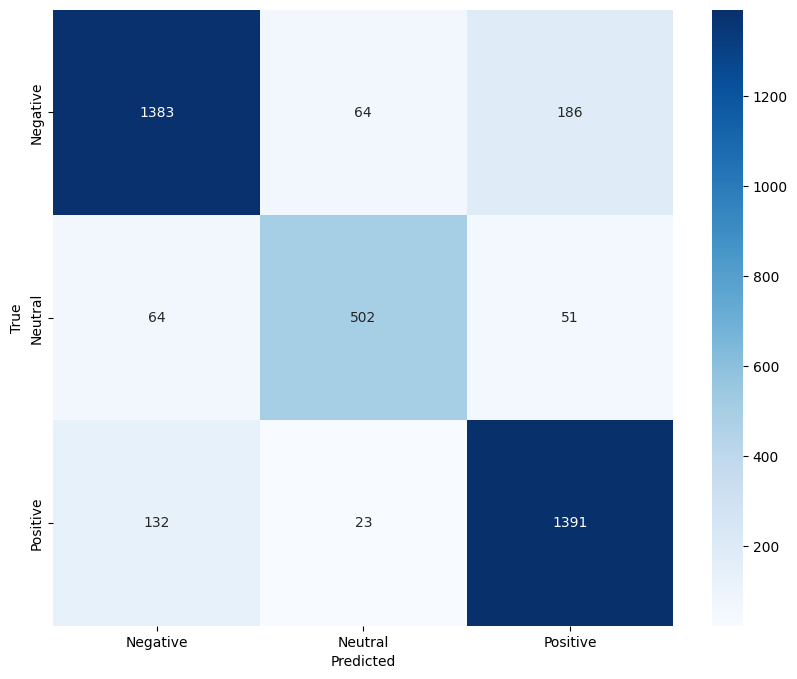

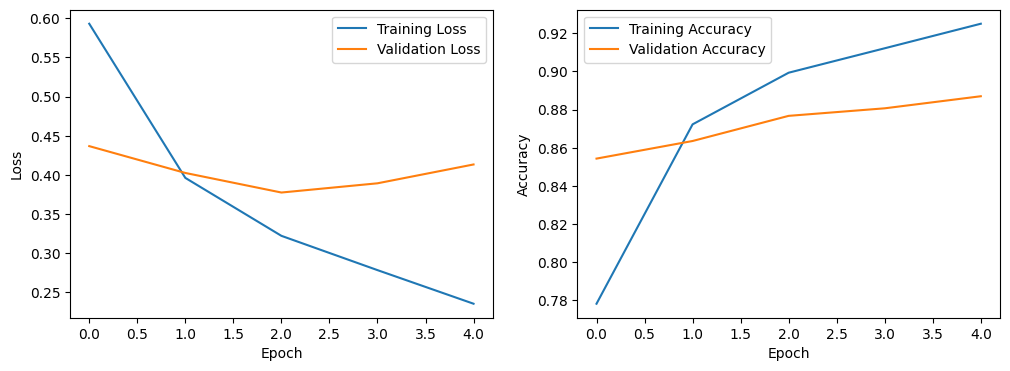

Negative: Precision=0.8758708043065231, Recall=0.8469075321494183, F1=0.8611457036114571
Neutral: Precision=0.8522920203735145, Recall=0.813614262560778, F1=0.8325041459369817
Positive: Precision=0.8544226044226044, Recall=0.8997412677878396, F1=0.876496534341525


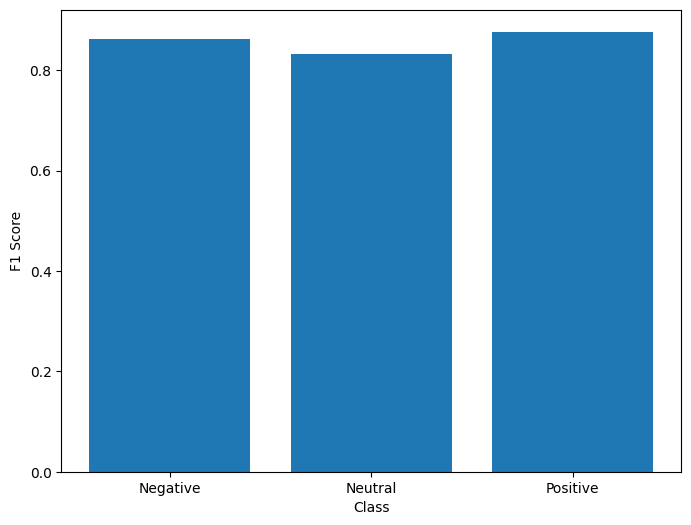

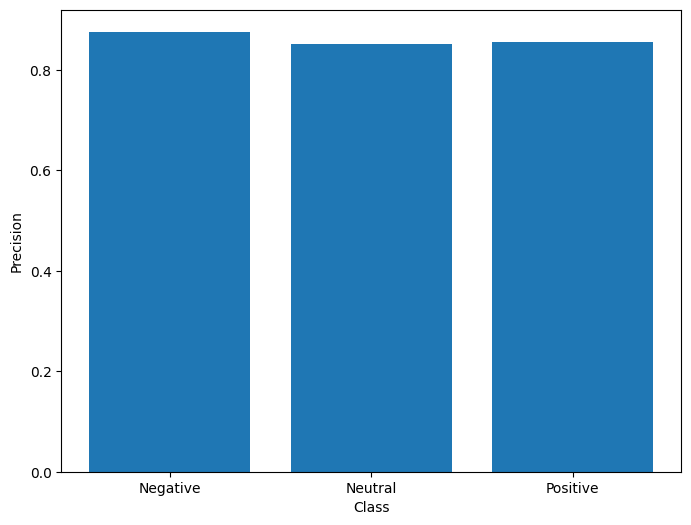

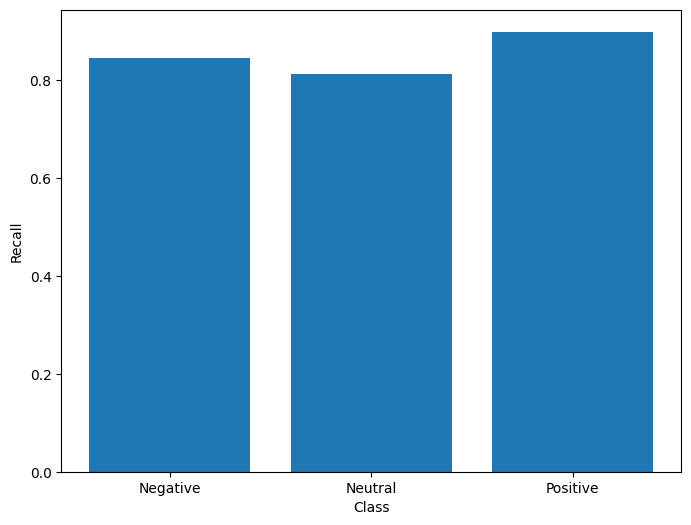

In [10]:
# Get the predicted labels for the test set
y_test_pred = roberta_model.predict([X_test_pad, X_test_mask]) # gather predicted labels by applying the trained model to the test data 
y_test_pred = np.argmax(y_test_pred.logits, axis=-1) # convert predicted labels from one-hot encoded format to class labels

# Compute and print the classification report
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
# This visualizes the performance of the model in predicting each class
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=target_names, yticklabels=target_names, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot the training/validation loss and accuracy over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compute and print the F1 score, precision, and recall for each class
p, r, f1, s = precision_recall_fscore_support(y_test, y_test_pred, average=None) # provides more detailed evaluation metrics
print('Negative: Precision={}, Recall={}, F1={}'.format(p[0], r[0], f1[0]))
print('Neutral: Precision={}, Recall={}, F1={}'.format(p[1], r[1], f1[1]))
print('Positive: Precision={}, Recall={}, F1={}'.format(p[2], r[2], f1[2]))

# Plot the F1 score, precision, and recall for each class using barplots
plt.figure(figsize=(8, 6))
plt.bar(target_names, f1)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(target_names, p)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(target_names, r)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.show()


119/119 [==============================] - 8s 65ms/step


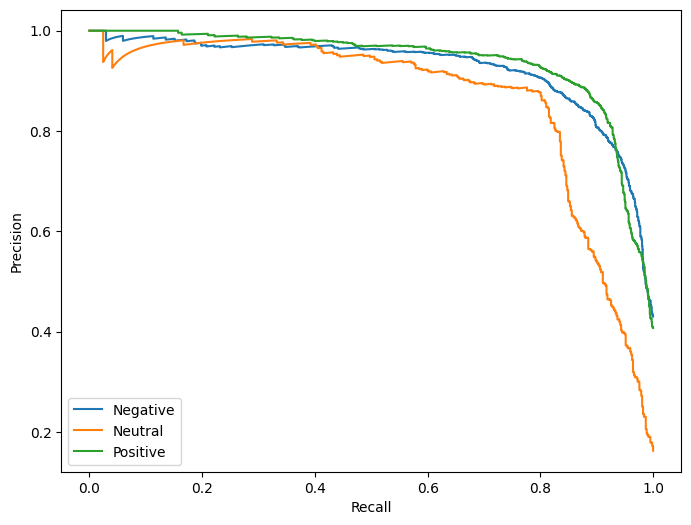

In [11]:
# Get the predicted probabilities for the test set
y_test_pred_prob = roberta_model.predict([X_test_pad, X_test_mask]).logits

# Compute the precision, recall, and F1 score for each class
p, r, f1, _ = precision_recall_fscore_support(y_test, np.argmax(y_test_pred_prob, axis=-1), average=None)

# Plot the precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(target_names)):
    precision, recall, _ = precision_recall_curve(y_test == i, y_test_pred_prob[:, i])
    plt.plot(recall, precision, label=target_names[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


In [12]:
# Get the predicted labels and probabilities for the test set
y_test_pred = roberta_model.predict([X_test_pad, X_test_mask]).logits
y_test_pred_label = np.argmax(y_test_pred, axis=-1)
y_test_pred_prob = tf.nn.softmax(y_test_pred, axis=-1)

119/119 [==============================] - 8s 66ms/step


              precision    recall  f1-score   support

    Negative       0.88      0.85      0.86      1633
     Neutral       0.85      0.81      0.83       617
    Positive       0.85      0.90      0.88      1546

    accuracy                           0.86      3796
   macro avg       0.86      0.85      0.86      3796
weighted avg       0.86      0.86      0.86      3796



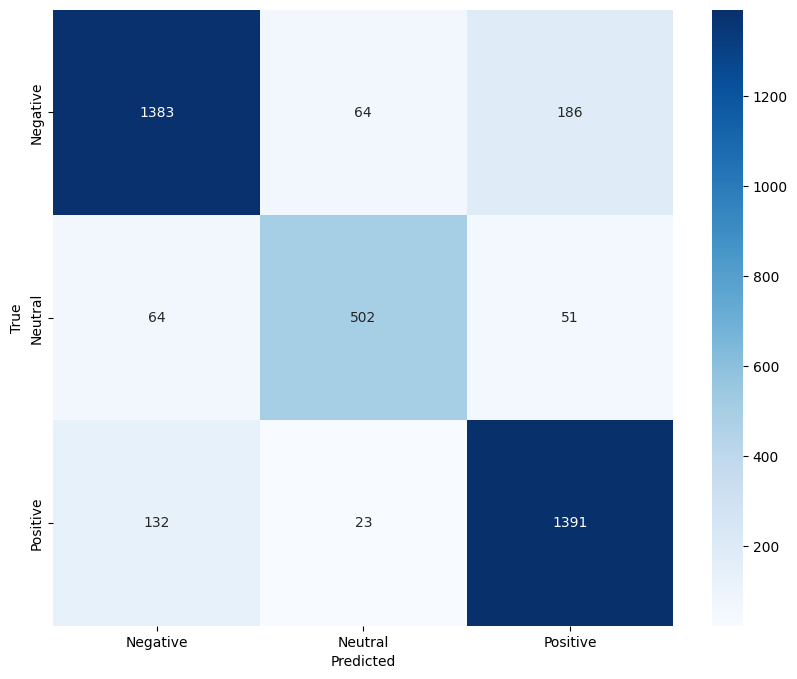

In [13]:
# Compute the classification report, confusion matrix, and PR-AUC score
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_test_pred_label, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred_label)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=target_names, yticklabels=target_names, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

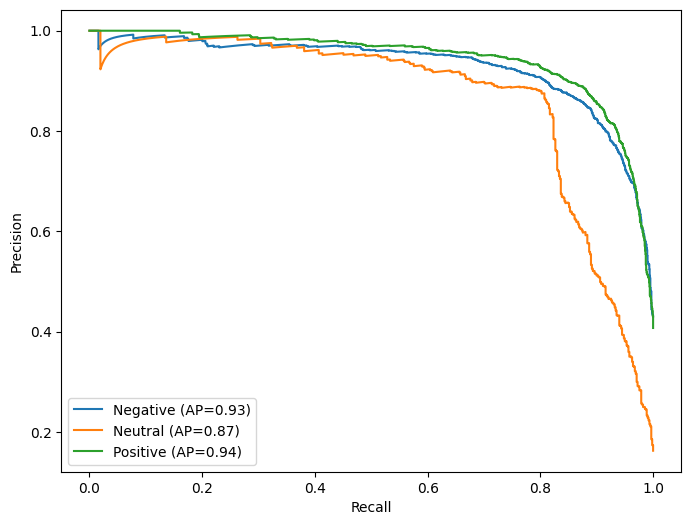

In [14]:
# Compute and plot the precision-recall curve and average precision score for each class
pr_auc_scores = []
plt.figure(figsize=(8, 6))
for i in range(len(target_names)):
    precision, recall, _ = precision_recall_curve((y_test == i).astype(int), y_test_pred_prob[:, i])
    pr_auc = average_precision_score((y_test == i).astype(int), y_test_pred_prob[:, i])
    pr_auc_scores.append(pr_auc)
    plt.plot(recall, precision, label=f'{target_names[i]} (AP={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

119/119 [==============================] - 8s 66ms/step


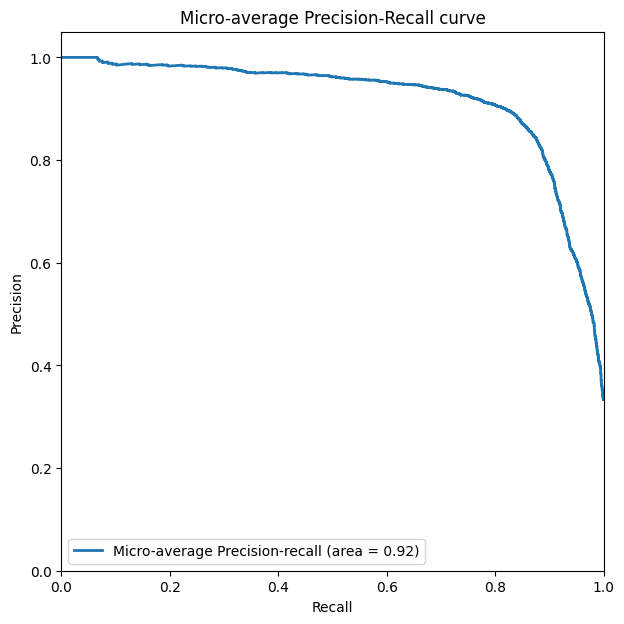

In [15]:
# Generate predictions
y_pred = roberta_model.predict([X_test_pad, X_test_mask])

# One-hot encode the true labels
y_test_encoded = label_binarize(y_test, classes=[0, 1, 2])

# Compute micro-average PR curve and PR-AUC
precision, recall, _ = precision_recall_curve(y_test_encoded.ravel(), y_pred.logits.ravel())
average_precision = average_precision_score(y_test_encoded, y_pred.logits, average="micro")

# Plot the micro-average Precision-Recall curve
plt.figure(figsize=(7, 7))
plt.plot(recall, precision, lw=2, label='Micro-average Precision-recall (area = {0:0.2f})'.format(average_precision))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-average Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()


In [17]:
np.save('Precision-Recall Curves/precision_micro_RoBERTa.npy', precision)
np.save('Precision-Recall Curves/recall_micro_bow_RoBERTa.npy', recall)

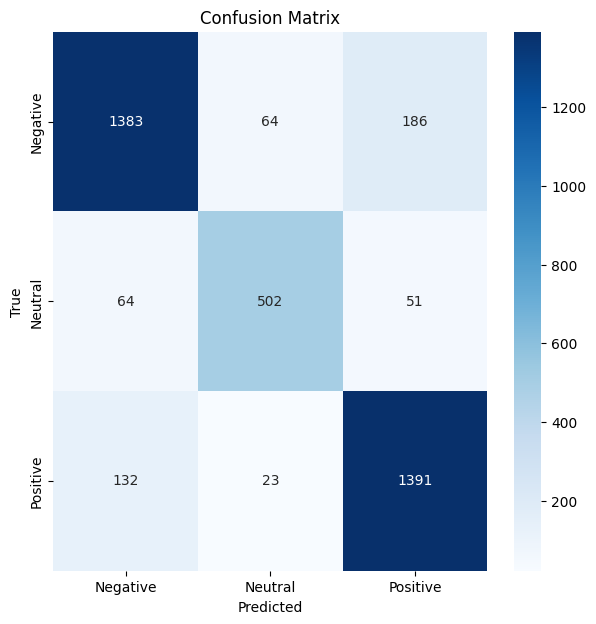

In [18]:
target_names = ['Negative', 'Neutral', 'Positive']

# Get predicted classes
y_pred_classes = np.argmax(y_pred.logits, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


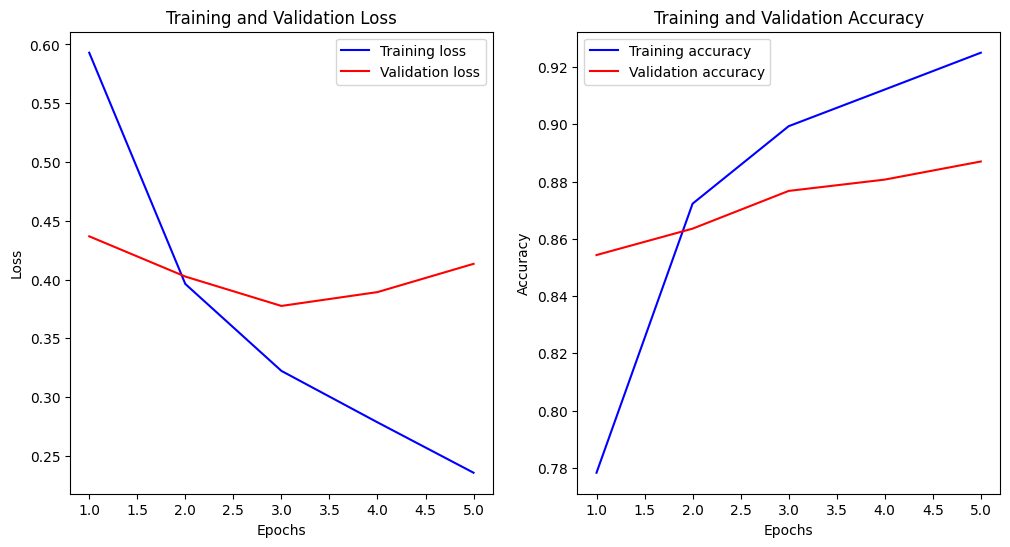

In [19]:
# Extract loss and accuracy values from history object obtained after training the model
training_loss = history.history['loss'] # stores the loss vals during training
val_loss = history.history['val_loss'] # stores the loss vals during validation
training_accuracy = history.history['categorical_accuracy'] # stores the accuracy vals during training
val_accuracy = history.history['val_categorical_accuracy'] # stores the accuracy vals during validation

epochs = range(1, len(training_loss) + 1)

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


#### ROC Curve and AUC-ROC Score (One-vs-Rest):
Perform a ROC curve analysis for a multi-class classification problem using the One-vs-Rest approach.

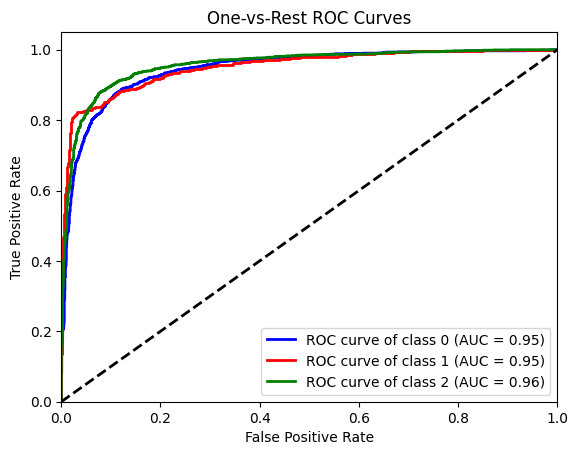

In [20]:
# Binarize the test labels and predictions
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
y_pred_probs = tf.nn.softmax(y_pred.logits).numpy() # predicted probabilities are obtained from the model's logits using a softmax activation function

# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict() # False Positive Rate (stores it for each class)
tpr = dict() # True Positive Rate (stores it for each class)
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i]) # compute the FPR, TPR, and thresholds for each class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves')
plt.legend(loc="lower right")
plt.show()
